In [ ]:
#pip install open-ephys-python-tools
import open_ephys.analysis
from open_ephys.analysis import Session
import matplotlib.pyplot as plt
import datetime
import numpy as np
from pynwb import NWBHDF5IO, NWBFile, TimeSeries




## GET THE DATA FROM ANAOLOG NIDAQ INPUT 

In [4]:
directory=f"D:\\Elia_Neuropixel\\2024-09-18_14-53-41"

session=Session(directory)
recording = session.recordnodes[0].recordings[0]
data = recording.continuous[1].get_samples(start_sample_index=0, end_sample_index=-1)

# print(len(session.recordnodes)) #this will just be 1 unless multiple neuropixels are plugged in 
# print(session.__dir__())
# session.directory
# session.mmap_timestamps
# session.recordnodes[0].recordings[0].continuous[1] #this is where nidaq is

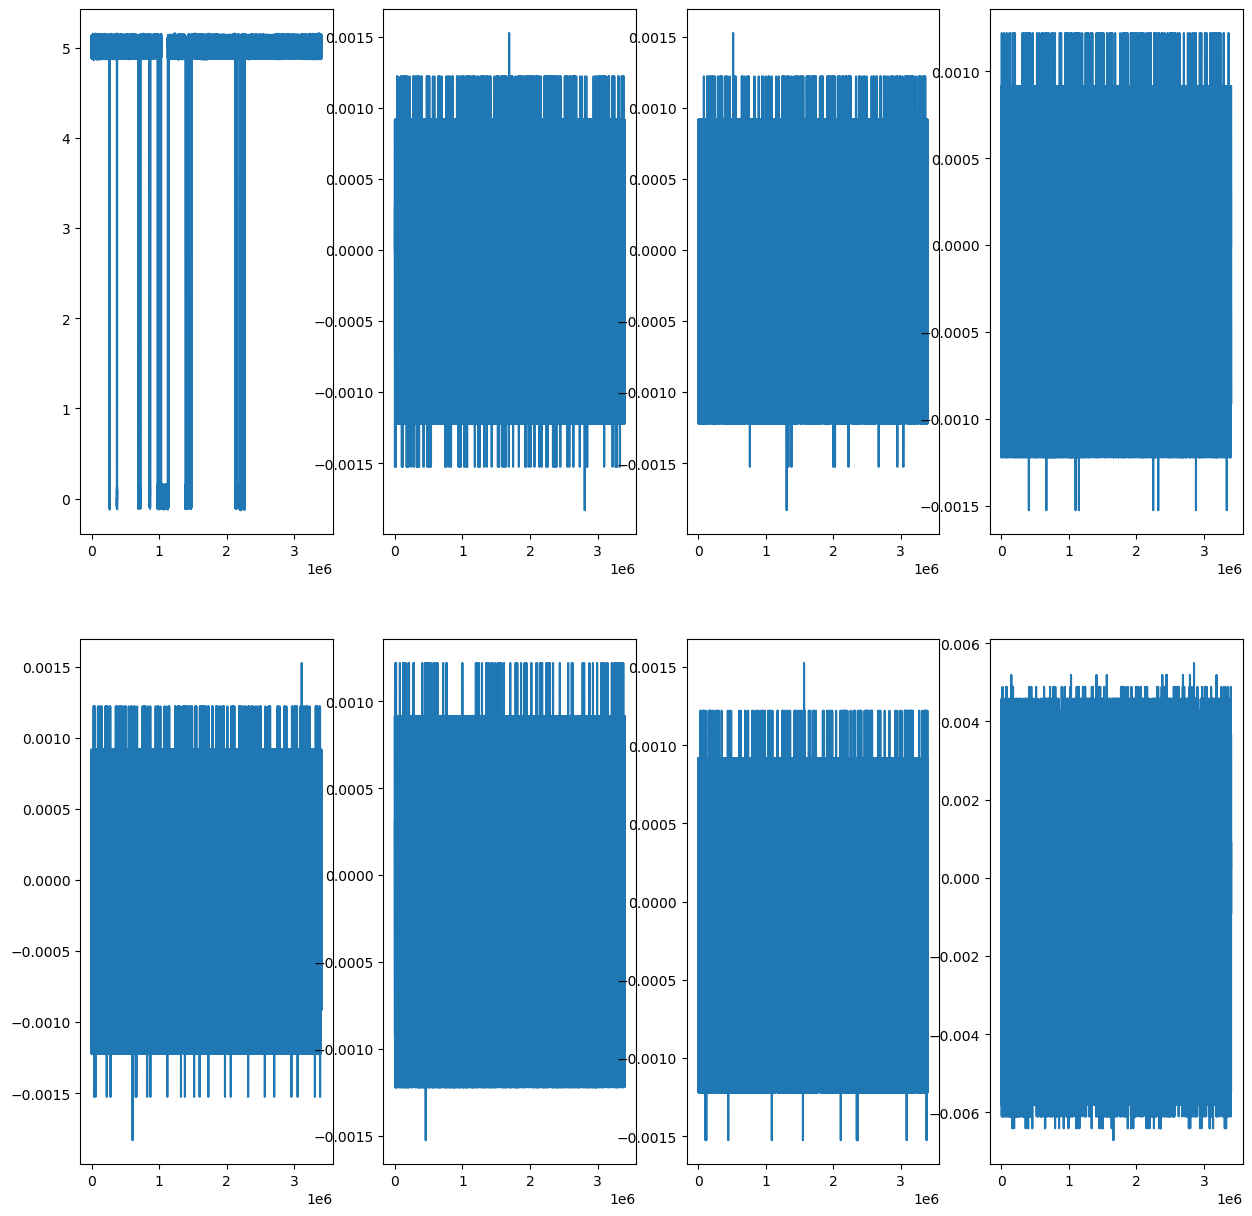

In [ ]:
# # PLOT TO FIND THE CUTOFF
fig, ax = plt.subplots(2,4, figsize=(15,15))

ax[0,0].plot((range(len(data[:,1]))),data[:,0])
ax[0,1].plot((range(len(data[:,1]))),data[:,1])
ax[0,2].plot((range(len(data[:,1]))),data[:,2])
ax[0,3].plot((range(len(data[:,1]))),data[:,3])
ax[1,0].plot((range(len(data[:,1]))),data[:,4])
ax[1,1].plot((range(len(data[:,1]))),data[:,5])
ax[1,2].plot((range(len(data[:,1]))),data[:,6])
ax[1,3].plot((range(len(data[:,1]))),data[:,7])

plt.show()


#plt.plot(xlabel,data[:,1])

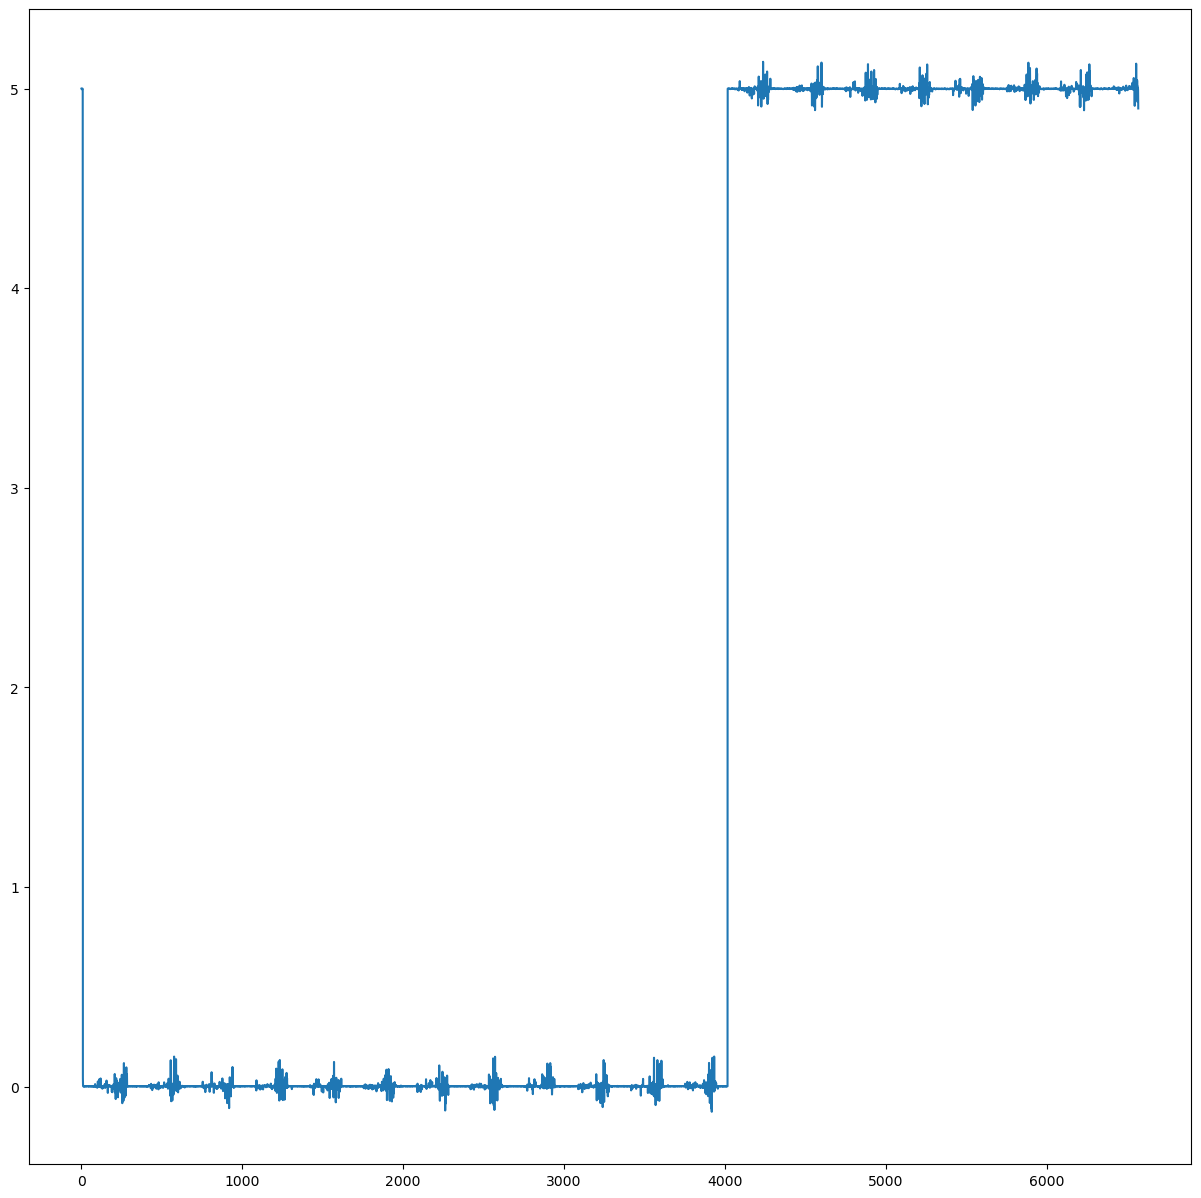

In [94]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

ax.plot((range(len(data[2261430:2268000,1]))),data[2261430:2268000,0])


In [97]:
def findTS_greaterthancutoff(signal, cutoff, sample):
    TS_index = [ind for ind, ele in enumerate(signal) if ele >= cutoff] 
    onset=list()
    onset.append(TS_index[0])

    for i in range(len(TS_index)-1):
        if TS_index[i+1]-TS_index[i]>1:
            onset.append(TS_index[i+1])
    
    TSonset=[x/sample for x in onset]
    return TSonset

def findTS_lessthancutoff(signal, cutoff, sample):
    TS_index = [ind for ind, ele in enumerate(signal) if ele <= cutoff] 
    offset=list()
    onset=list()
    onset.append(TS_index[0])

    for i in range(len(TS_index)-1):
        if TS_index[i+1]-TS_index[i]>1:
            offset.append(TS_index[i])
            onset.append(TS_index[i+1])
    offset.append(TS_index[-1])
    
    TSoffset=[x/sample for x in offset]
    TSonset=[x/sample for x in onset]

    return TSonset, TSoffset



## TS for lick - analog input 0

In [ ]:
## FIND TS FOR headfix lick - analog input 0

#Set the variables for consistant across recordings - cutoff and sampling rate
cutoff=3
sample=30000

#event 0
signal=data[:,0]
npx_lickon, npx_lickoff = findTS_lessthancutoff(signal,cutoff,sample)



## START AND STOP TIME OF EACH TRIAL - 1S PRE/POST LICK

In [99]:
#To get time intervals for each trial for NWB
# this will be a little confusing until there are cues
#NWB likes to have behavior data in 'trials' so teh start/end of trials 
# will be a little arbitrary right now - 1 second prior tp lick on and 1 sec after lick off 


npx_startTrial=[]
for i in range(len(npx_lickon)):
    npx_startTrial.append(float(npx_lickon[i]-1))
npx_startTrial=np.array(npx_startTrial)
# npx_startTrial+=npx_startTime


npx_stopTrial=[]
for i in range(len(npx_lickoff)):
    npx_stopTrial.append(float(npx_lickoff[i]+1))
npx_stopTrial=np.array(npx_stopTrial)


## ADD TRIALS IN NWB

In [100]:
# confirm the file contains the new TimeSeries in acquisition
filename = 'PRACTICE'

with NWBHDF5IO(f"F:\\EMR22010\\NWB\\{filename}.nwb", "r+") as io:
    read_nwbfile = io.read()

    read_nwbfile.add_trial_column(name="lick_on", description="Timestamp of lick onset")
    read_nwbfile.add_trial_column(name="lick_off", description="Timestamp of lick offset")

    for i in range(len(npx_startTrial)):

        read_nwbfile.add_trial(
            start_time=float(npx_startTrial[i]),
            stop_time=float(npx_stopTrial[i]),
            lick_on=float(npx_lickon[i]),
            lick_off=float(npx_lickoff[i])
        )

    io.write(read_nwbfile)
    io.close()
    #print(read_nwbfile.acquisition)


## GET TRIALS FROM NWB - SANITY CHECK

In [102]:
# io.close()
# confirm the file contains the new TimeSeries in acquisition

filename = 'PRACTICE'
with NWBHDF5IO(f"F:\\EMR22010\\NWB\\{filename}.nwb", "r+") as io:
    read_nwbfile = io.read()
    trials=read_nwbfile.trials
    trials_df=trials.to_dataframe()
    print(trials)
    

trials pynwb.epoch.TimeIntervals at 0x2923117745392
Fields:
  colnames: ['start_time' 'stop_time' 'lick_on' 'lick_off']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    lick_on <class 'hdmf.common.table.VectorData'>,
    lick_off <class 'hdmf.common.table.VectorData'>
  )
  description: experimental trials
  id: id <class 'hdmf.common.table.ElementIdentifiers'>



In [103]:

trials_df.head()


,start_time,stop_time,lick_on,lick_off
id,,,,
0,7.858200,9.991733,8.858200,8.991733
1,11.464867,13.598400,12.464867,12.598400
2,22.151300,24.284867,23.151300,23.284867
3,22.685633,24.819167,23.685633,23.819167
4,22.952800,25.219900,23.952800,24.219900
